In [ ]:
"""
4 exp 4 temps

self dist
self dist shifted
mlp vanilla
cnn vanilla
cnn mlp 
cnn stupider + mlp
fidelity of mlp to t' cross fidelity wrt first cnn - 1 plot

accuracy NLL ECE 

top1 agreement between teacher and student,
KL divergence, invariance metric (crossentropy?) -> show patrick it's better

FLOPS!!
"""

In [2]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.cnn import SimpleCNN
from models.resnet import resnet18_mnist
from models.mlp import MLP
from distillation_utils import Distiller
from invariances_utils import shift_preserving_shape, test_IM, validate
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import deepspeed

ModuleNotFoundError: No module named 'deepspeed'

In [ ]:
# in_channels = 1
# num_conv_layers = 2
num_epochs = 10
num_classes = 10
batch_size = 64
lr = 0.001
TRAIN = False
device = 'cuda'
temperature = 1

In [6]:
# MNIST dataset

# Define a custom dataset that combines MNIST and additional data
class ShiftAugmentedMNIST(Dataset):
    def __init__(self, mnist_dataset, translation_times : int = 5, max_shift : int = 5):
        self.mnist_dataset = mnist_dataset
        directions = ["u","d","l","r"]
        self.translations = []
        for i in range(len(self.mnist_dataset)):
            img, label = self.mnist_dataset[i]
            img = img.squeeze()
            for t in range(translation_times):
                sh = shift_preserving_shape(img, direction=directions[np.random.randint(0,4)],
                                            max_shift=max_shift).unsqueeze(0)
                if sh is not None:
                    self.translations.append((sh, label))

    def __getitem__(self, index):
        if index < len(self.mnist_dataset):
            return self.mnist_dataset[index]
        else:
            return self.translations[index - len(self.mnist_dataset)]

    def __len__(self):
        return len(self.mnist_dataset) + len(self.translations)


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

train_augmented_dataset = ShiftAugmentedMNIST(train_dataset)
train_augmented_loader = DataLoader(dataset=train_augmented_dataset, batch_size=batch_size, shuffle=True)

Undistilled MLP

Not using softmax
Correct normal: 0.9714
Correct shifted: 0.2985

accu: 0.97153664

nlll: 0.10431392

ecel: 0.03115510

test_IM: 0.89523607



{'accu': 0.9715366363525391,
 'nlll': 0.1043139174580574,
 'ecel': 0.03115510381758213,
 'test_IM': tensor(0.8952, device='cuda:0')}

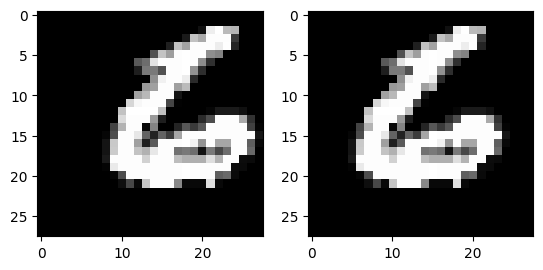

In [6]:
#Loading undistilled MLP
if TRAIN:
    undistilled_mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
        hidden_layers= 4, device='cuda')
    criterion_mlp = torch.nn.CrossEntropyLoss()
    optimizer_mlp = torch.optim.Adam(undistilled_mlp.parameters(), lr=lr)
    undistilled_mlp.training_loop(train_loader=train_loader, optimizer=optimizer_mlp, criterion=criterion_mlp, 
              num_epochs=5, save_path_folder="saved_models_undistilled")
if not TRAIN:
    undistilled_mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models_undistilled/mlp")

validate(model=undistilled_mlp, weights_file="saved_models_undistilled/mlp", valid_data=test_loader, device=device, is_mlp= True)

Undistilled MLP Augmented

In [ ]:
#Loading undistilled MLP augmented
if TRAIN:
    undistilled_mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
        hidden_layers= 4, device='cuda')
    criterion_mlp = torch.nn.CrossEntropyLoss()
    optimizer_mlp = torch.optim.Adam(undistilled_mlp.parameters(), lr=lr)
    undistilled_mlp.training_loop(train_loader=train_augmented_loader, optimizer=optimizer_mlp, criterion=criterion_mlp, 
              num_epochs=5, save_path_folder="saved_models_undistilled_augmented")
if not TRAIN:
    undistilled_mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models_undistilled_augmented/mlp")

validate(model=undistilled_mlp, weights_file="saved_models_undistilled_augmented/mlp", valid_data=test_loader, device=device, is_mlp= True)

CNN_1

In [ ]:
#Obtaining CNN
cnn_path = "saved_cnn/model_1"
#cnn = SimpleCNN(in_channels=in_channels, num_classes=num_classes, num_conv_layers=num_conv_layers, temperature=temperature).to('cuda:0')
cnn = resnet18_mnist().to(device)
if TRAIN:
    criterion_cnn = torch.nn.CrossEntropyLoss()
    optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr)
    # model training
    prof = deepspeed.profiling.flops.profiler.FlopsProfiler(cnn)
    profile_epoch = 0
    for epoch in range(num_epochs):
        if epoch == profile_epoch:
            prof.start_profile()
        for i, (images, labels) in enumerate(train_loader):
            outputs = cnn(images.to(device))
            loss = criterion_cnn(outputs, labels.to(device))

            optimizer_cnn.zero_grad()
            loss.backward()
            optimizer_cnn.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            if epoch == profile_epoch and i == 0:
                prof.stop_profile()
                flops = prof.get_total_flops()
                prof.end_profile()
    # Save the trained model
    torch.save(cnn.state_dict(), cnn_path)
    print(f"Model saved as {cnn_path}!")
    print("Model flops: ", flops)
if not TRAIN:
    state_dict = torch.load(cnn_path)
    cnn.load_state_dict(state_dict=state_dict)

validate(model=undistilled_mlp, weights_file=cnn_path, valid_data=test_loader, device=device, is_mlp= False)


CNN_2

In [ ]:
# TODO: create second "stupid" cnn model (at the moment it is the same)
#Obtaining CNN
cnn_path = "saved_cnn/model_2"
#cnn = SimpleCNN(in_channels=in_channels, num_classes=num_classes, num_conv_layers=num_conv_layers, temperature=temperature).to('cuda:0')
cnn = resnet18_mnist().to(device)
if TRAIN:
    criterion_cnn = torch.nn.CrossEntropyLoss()
    optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr)
    # model training
    prof = deepspeed.profiling.flops.profiler.FlopsProfiler(cnn)
    profile_epoch = 0
    for epoch in range(num_epochs):
        if epoch == profile_epoch:
            prof.start_profile()
        for i, (images, labels) in enumerate(train_loader):
            outputs = cnn(images.to(device))
            loss = criterion_cnn(outputs, labels.to(device))

            optimizer_cnn.zero_grad()
            loss.backward()
            optimizer_cnn.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            if epoch == profile_epoch and i == 0:
                prof.stop_profile()
                flops = prof.get_total_flops()
                prof.end_profile()
    # Save the trained model
    torch.save(cnn.state_dict(), cnn_path)
    print(f"Model saved as {cnn_path}!")
    print("Model flops: ", flops)
if not TRAIN:
    state_dict = torch.load(cnn_path)
    cnn.load_state_dict(state_dict=state_dict)

validate(model=undistilled_mlp, weights_file=cnn_path, valid_data=test_loader, device=device, is_mlp= False)


Self distilling MLP 

In [ ]:
#Self distilling MLP (only from unshifted data)
save_path_folder = "saved_models_selfdistill_unshifted"
teacher_path = "saved_models_undistilled/mlp"
#Self distillation: mlp_student and mlp teacher coincide #TODO CHECK
mlp_student = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device=device)

mlp_teacher = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device=device, from_saved_state_dict=teacher_path)

if TRAIN:
    selfdistiller = Distiller(student=mlp_student, teacher=mlp_teacher, device=device, lr=0.001)
    selfdistiller.distill(train_loader, 5, save_path_folder) # TODO the model will not be saved in distill() or is it inherited??
    # selfdistiller.test_step(test_loader=test_loader) TODO: there is not test_step method?
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher, weights_file=teacher_path, valid_data=test_loader, device=device, is_mlp= True)
    validate(model=mlp_student, weights_file=save_path_folder + 'distiller', valid_data=test_loader, device=device, is_mlp= True)
if not TRAIN:
    print("Loading params")
    selfdistiller = Distiller(student=mlp_student, teacher=mlp_teacher, device=device, lr=0.001,
                        load_student_from_path = save_path_folder + 'distiller')
    # selfdistiller.test_step(test_loader=test_loader) TODO: there is not test_step method?
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher, weights_file=teacher_path, valid_data=test_loader, device=device, is_mlp= True)
    validate(model=mlp_student, weights_file=save_path_folder + 'distiller', valid_data=test_loader, device=device, is_mlp= True)

Self distilling MLP Augmented

In [ ]:
#Self distilling MLP (augmented)
# TODO: Do we use train_loader or train_augmented_loader in distill?
save_path_folder = "saved_models_selfdistill_augmented"
teacher_path = "saved_models_undistilled_augmented/mlp"
#Self distillation: mlp_student and mlp teacher coincide #TODO CHECK
mlp_student = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device=device)

mlp_teacher = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device=device, from_saved_state_dict=teacher_path)

if TRAIN:
    selfdistiller = Distiller(student=mlp_student, teacher=mlp_teacher, device=device, lr=0.001)
    selfdistiller.distill(train_loader, 5, save_path_folder) # TODO the model is not saved in distill() or is it inherited??
    # selfdistiller.test_step(test_loader=test_loader) TODO: there is not test_step method?
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher, weights_file=teacher_path, valid_data=test_loader, device=device, is_mlp= True)
    validate(model=mlp_student, weights_file=save_path_folder + 'distiller', valid_data=test_loader, device=device, is_mlp= True)
if not TRAIN:
    print("Loading params")
    selfdistiller = Distiller(student=mlp_student, teacher=mlp_teacher, device=device, lr=0.001,
                        load_student_from_path = save_path_folder + 'distiller')
    # selfdistiller.test_step(test_loader=test_loader) TODO: there is not test_step method?
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher, weights_file=teacher_path, valid_data=test_loader, device=device, is_mlp= True)
    validate(model=mlp_student, weights_file=save_path_folder + 'distiller', valid_data=test_loader, device=device, is_mlp= True)

Distilling CNN_1 -> MLP_1 

Distilling CNN_2 -> MLP_2

In [ ]:
#Distilling CNN to MLP
save_path_folder_1 = "saved_models_distill_cnn1_to_mlp1"
save_path_folder_2 = "saved_models_distill_cnn2_to_mlp2"
teacher_path_1 = "saved_cnn/model_1"
teacher_path_2 = "saved_cnn/model_2"

mlp_student_1 = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device=device)

mlp_student_2 = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device=device)

mlp_teacher_1 = resnet18_mnist(from_saved_state_dict=teacher_path_1).to(device)

#TODO: use different architecture than mlp_teacher_1 (at the moment it is the same)
mlp_teacher_2 = resnet18_mnist(from_saved_state_dict=teacher_path_2).to(device)

if TRAIN:
    selfdistiller = Distiller(student=mlp_student_1, teacher=mlp_teacher_1, device=device, lr=0.001)
    selfdistiller.distill(train_loader, 5, save_path_folder) # TODO the model is not saved in distill() or is it inherited??
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher_1, weights_file=teacher_path_1, valid_data=test_loader, device=device, is_mlp= False)
    validate(model=mlp_student_1, weights_file=save_path_folder_1 + 'distiller', valid_data=test_loader, device=device, is_mlp= True)

    selfdistiller = Distiller(student=mlp_student_2, teacher=mlp_teacher_2, device=device, lr=0.001)
    selfdistiller.distill(train_loader, 5, save_path_folder) # TODO the model is not saved in distill() or is it inherited??
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher_2, weights_file=teacher_path_2, valid_data=test_loader, device=device, is_mlp= False)
    validate(model=mlp_student_2, weights_file=save_path_folder_2 + 'distiller', valid_data=test_loader, device=device, is_mlp= True)

    selfdistiller = Distiller(student=mlp_student_2, teacher=mlp_teacher_1, device=device, lr=0.001,
                        load_student_from_path = save_path_folder_2 + 'distiller')
    selfdistiller.compute_fidelity(test_loader) # compute fidelity of mlp2 and teacher1
if not TRAIN:
    print("Loading params")
    selfdistiller = Distiller(student=mlp_student_1, teacher=mlp_teacher_1, device=device, lr=0.001,
                        load_student_from_path = save_path_folder_1 + 'distiller')
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher_1, weights_file=teacher_path_1, valid_data=test_loader, device=device, is_mlp= False)
    validate(model=mlp_student_1, weights_file=save_path_folder_1 + 'distiller', valid_data=test_loader, device=device, is_mlp= True)

    selfdistiller = Distiller(student=mlp_student_2, teacher=mlp_teacher_2, device=device, lr=0.001,
                        load_student_from_path = save_path_folder_2 + 'distiller')
    selfdistiller.compute_fidelity(test_loader)
    validate(model=mlp_teacher_2, weights_file=teacher_path_2, valid_data=test_loader, device=device, is_mlp= False)
    validate(model=mlp_student_2, weights_file=save_path_folder_2 + 'distiller', valid_data=test_loader, device=device, is_mlp= True)

    selfdistiller = Distiller(student=mlp_student_2, teacher=mlp_teacher_1, device=device, lr=0.001,
                        load_student_from_path = save_path_folder_2 + 'distiller')
    selfdistiller.compute_fidelity(test_loader) # compute fidelity of mlp2 and teacher1